In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip '/content/drive/MyDrive/ResearchWork_2023/Single_disease/train_images.zip'
!unzip '/content/drive/MyDrive/ResearchWork_2023/Single_disease/test_images.zip'
!unzip '/content/drive/MyDrive/ResearchWork_2023/Single_disease/val_images.zip'

Archive:  /content/drive/MyDrive/ResearchWork_2023/Single_disease/train_images.zip
replace train_cropped_images/4689_right.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/MyDrive/ResearchWork_2023/Single_disease/test_images.zip
replace test_cropped_images/4999_right.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/MyDrive/ResearchWork_2023/Single_disease/val_images.zip
replace val_cropped_images/4761_right.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
# Load the pre-trained Inception-ResNet-V2 model
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(299,299,3))

# Freeze the pre-trained weights
base_model.trainable = False

base_model.layers[-1].trainable = True
base_model.layers[-2].trainable = True

# Pass the input layer through the pre-trained model
features = base_model.output

outputs = tf.keras.layers.Flatten()(features)
outputs = tf.keras.layers.Dropout(0.5)(outputs)
outputs = tf.keras.layers.Dense(units=8, activation='softmax', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))(outputs)

In [5]:
# !pip install tensorflow_addons
# import tensorflow_addons as tfa
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
# f1_score = tfa.metrics.F1Score(num_classes=8)
categorical_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [6]:

# Create the model
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
# Compile the model
# base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
               loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[categorical_accuracy, precision , recall])

In [7]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0     

In [8]:

# Load the image data and one-hot encoded multi-label data
# Load the data from the excel sheet into a pandas dataframe
# Load both left and right eye dataset
base_path = '/content/drive/MyDrive/ResearchWork_2023/Single_disease'
train_df = pd.read_excel(f'{base_path}/train_undersampled_labels.xlsx')
test_df = pd.read_excel(f'{base_path}/test_labels.xlsx')
val_df = pd.read_excel(f'{base_path}/val_undersampled_labels.xlsx')


In [9]:
train_df

,Unnamed: 0,Fundus,Diagnostic_Keywords,N,D,G,C,A,H,M,O
0,322,4678_left.jpg,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0
1,408,4404_right.jpg,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
2,405,4374_right.jpg,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0
3,462,1246_left.jpg,glaucoma,0,0,1,0,0,0,0,0
4,1509,1617_right.jpg,pathological myopia,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1747,1130,1091_right.jpg,dry age-related macular degeneration,0,0,0,0,1,0,0,0
1748,1294,144_left.jpg,pathological myopia,0,0,0,0,0,0,1,0
1749,860,2133_right.jpg,cataract,0,0,0,1,0,0,0,0
1750,1459,1549_right.jpg,pathological myopia,0,0,0,0,0,0,1,0


# Train

In [10]:
# Split the data into two arrays, one for the image paths and one for the labels
train_images_base_path = '/content/train_cropped_images/'
image_paths = train_images_base_path + train_df["Fundus"].values
labels = train_df.iloc[:, 3:].values

# Convert the lists to tensors
image_paths = tf.constant(image_paths)
labels = tf.constant(labels)

# Create a dataset from the image paths and labels
train_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

# Test

In [11]:

# Split the data into two arrays, one for the image paths and one for the labels
test_images_base_path = '/content/test_cropped_images/'
image_paths = test_images_base_path + test_df["Fundus"].values
labels = test_df.iloc[:, 5:].values

# Convert the lists to tensors
image_paths = tf.constant(image_paths)
labels = tf.constant(labels)

# Create a dataset from the image paths and labels
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

# Validation

In [12]:
# Split the data into two arrays, one for the image paths and one for the labels
val_images_base_path = '/content/val_cropped_images/'
image_paths = val_images_base_path + val_df["Fundus"].values
labels = val_df.iloc[:, 3:].values

# Convert the lists to tensors
image_paths = tf.constant(image_paths)
labels = tf.constant(labels)

# Create a dataset from the image paths and labels
val_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

In [13]:
# Load the images and preprocess them
def load_and_preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])
    image = tf.keras.applications.vgg19.preprocess_input(image)
    return image, label

# Apply the load_and_preprocess_image function to the dataset
train_dataset = train_dataset.map(load_and_preprocess_image)
test_dataset = test_dataset.map(load_and_preprocess_image)
val_dataset = val_dataset.map(load_and_preprocess_image)

# Shuffle the data and batch it
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size)

In [14]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int64, name=None))>

In [15]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int64, name=None))>

In [16]:
val_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int64, name=None))>

In [17]:
# Train the model
history=model.fit(train_dataset, epochs=10, batch_size=batch_size, validation_data=val_dataset)

Epoch 1/10
55/55 [==============================] - 53s 686ms/step - loss: 30.2098 - categorical_accuracy: 0.1792 - precision: 0.1795 - recall: 0.1741 - val_loss: 23.7278 - val_categorical_accuracy: 0.2669 - val_precision: 0.2727 - val_recall: 0.2481
Epoch 2/10
55/55 [==============================] - 31s 506ms/step - loss: 26.4508 - categorical_accuracy: 0.2900 - precision: 0.2937 - recall: 0.2803 - val_loss: 22.2220 - val_categorical_accuracy: 0.3459 - val_precision: 0.3708 - val_recall: 0.3346
Epoch 3/10
55/55 [==============================] - 31s 474ms/step - loss: 24.3330 - categorical_accuracy: 0.3425 - precision: 0.3490 - recall: 0.3356 - val_loss: 21.2670 - val_categorical_accuracy: 0.3609 - val_precision: 0.3917 - val_recall: 0.3534
Epoch 4/10
55/55 [==============================] - 31s 479ms/step - loss: 22.7172 - categorical_accuracy: 0.3990 - precision: 0.4032 - recall: 0.3864 - val_loss: 20.4343 - val_categorical_accuracy: 0.3759 - val_precision: 0.4034 - val_recall: 0.3

In [18]:
model.save('/content/drive/MyDrive/ResearchWork_2023/models/model_undersample_2.h5')

In [19]:
import matplotlib.pyplot as plt

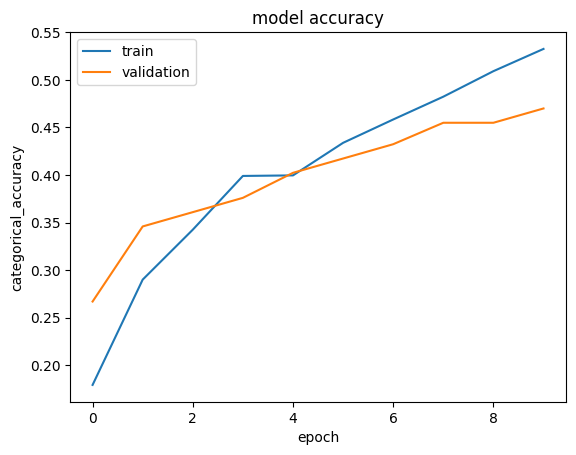

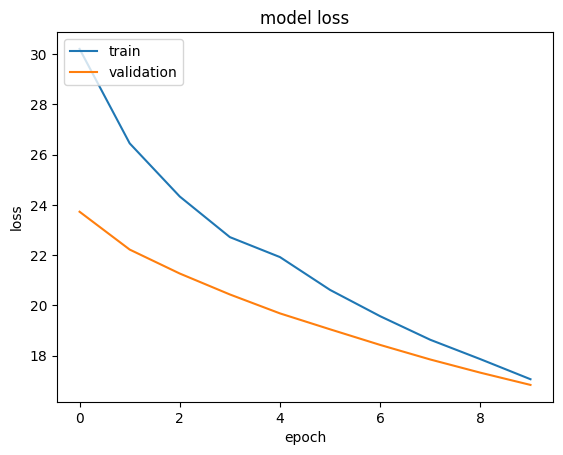

In [20]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
result = model.evaluate(test_dataset)
result

60/60 [==============================] - 32s 410ms/step - loss: 18.2544 - categorical_accuracy: 0.2614 - precision: 0.2640 - recall: 0.2244


[18.25440216064453,
 0.26135164499282837,
 0.2639751434326172,
 0.2243928164243698]

In [22]:
# load_model = tf.keras.saving.load_model('/content/drive/MyDrive/ResearchWork_2023/models/model_4.h5',compile=False)

In [23]:
import numpy as np

# Assuming you have a test dataset 'test_data' with image tensors and corresponding labels
predictions = []
true_labels = []

# Iterate over the test dataset and make predictions
for images, labels in test_dataset:
    preds = model.predict(images)
    predictions.extend(np.argmax(preds, axis=1))
    true_labels.extend(np.argmax(labels, axis=1))

# Compute the confusion matrix
cm = tf.math.confusion_matrix(true_labels, predictions)

# Convert the confusion matrix to a NumPy array and print it
print("Confusion Matrix:")
print(cm.numpy())


1/1 [==============================] - 0s 138ms/step
Confusion Matrix:
[[196 175 145  22  75  42  30 134]
 [ 43  45  10   3  19  16   3  39]
 [ 11   4  27   7   2   1   5   8]
 [  0   1   2  76   1   0   0   1]
 [ 13  11  10   2  15   4   3  12]
 [  6   6   0   1   1   3   1   9]
 [  2   0   2   3   1   0  48   2]
 [ 80  87  74  33  80  12 145  85]]
